# Dimensionality Reduction
## Notebook accompanying Lecture 12 in T-498-GAGR

Content
1. A few words on `scikit-learn`
2. Dimensionality reduction
     1. Redunant variables
     2. PCA
     3. LDA
     4. Other DR methods
     
## 0. Intro

In [203]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import statsmodels.api as sm

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

%matplotlib inline

In [204]:
try:
    import common
    DATA = common.dataDirectory()
except ImportError:
    DATA = Path().resolve() / 'data'

In [205]:
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'

## 1. A few words on scikit-learn
First we demonstrate the **consistency** in using `scikit-learn` using the loans dataset.
We show how to do pre-processing, how to build data processing pipelines and how to build prediction models.

We start by reading and viewing the dataset.

In [206]:
loan = pd.read_csv(LOAN_DATA_CSV, index_col=0)
loan.head()

,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,home_ownership,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,RENT,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,OWN,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,RENT,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,RENT,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,RENT,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [207]:
loan.describe()

,loan_amnt,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,emp_length,borrower_score
count,45342.000000,4.534200e+04,45342.000000,45342.000000,4.534200e+04,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000,45342.000000
mean,13154.814521,6.821170e+04,16.133731,8.032225,1.485745e+04,56.051800,0.857527,0.912090,10.413105,4.599087,6.321115,0.499006
std,8088.533525,5.623902e+04,7.594881,4.264034,2.008254e+04,25.430276,0.349538,0.283167,4.696616,1.479069,3.752789,0.128687
min,500.000000,2.000000e+03,0.000000,0.048892,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.050000
25%,7000.000000,4.200000e+04,10.460000,4.671572,5.657000e+03,37.900000,1.000000,1.000000,7.000000,3.600000,3.000000,0.400000
50%,11500.000000,6.000000e+04,16.020000,7.499355,1.076550e+04,58.400000,1.000000,1.000000,10.000000,4.800000,6.000000,0.500000
75%,18000.000000,8.100000e+04,21.590000,10.940575,1.861350e+04,76.400000,1.000000,1.000000,13.000000,5.800000,11.000000,0.600000
max,35000.000000,7.141778e+06,38.860000,43.545600,1.743266e+06,128.100000,1.000000,1.000000,76.000000,7.000000,11.000000,1.000000


We seperate the target variable from the dataset (called outcome) and we remove some variables for simplicity.
We also split the dataset into two parts
* `loan_cat` which contains the categorical variables 
* `loan_num` which contains the numeric variables



In [208]:
loan_label=loan[['outcome']]
loan=loan.drop(['emp_length', 'purpose_', 'home_', 'emp_len_', 'borrower_score','outcome'],axis=1)
loan_cat=loan[['status','term','purpose','home_ownership']]
loan_num=loan.drop(['status','term','purpose','home_ownership'],axis=1)

### We start with some preprocessing.
Our goal here is to convert some of the categorical variables using the `OrdinalEncoder` module.
We start by creating an `OrdinalEncoder()`object and then 
1. we estiamte the parameters by callin the `fit()` mehtod on our dataset 
2. we transform the data set using the `transform()` method

Alternatively we can use the method `fit_transform()`.

In [210]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder=OrdinalEncoder()
ordinal_encoder.fit(loan_cat)
loan_cat_encoded=ordinal_encoder.transform(loan_cat)
#loan_cat_encoded=ordinal_encoder.fit_transform(loan_cat)
loan_cat_encoded[:10]

array([[0., 1., 0., 3.],
       [0., 1., 9., 2.],
       [0., 1., 8., 3.],
       [0., 0., 2., 3.],
       [0., 0., 8., 3.],
       [0., 0., 2., 3.],
       [0., 0., 5., 3.],
       [0., 0., 2., 3.],
       [0., 1., 8., 3.],
       [0., 0., 2., 0.]])

We can inspect the categories which the ordinal encoder gives.

In [105]:
ordinal_encoder.categories_

[array(['Charged Off', 'Default', 'Fully Paid'], dtype=object),
 array(['36 months', '60 months'], dtype=object),
 array(['car', 'credit_card', 'debt_consolidation', 'home_improvement',
        'house', 'major_purchase', 'medical', 'moving', 'other',
        'small_business', 'vacation', 'wedding'], dtype=object),
 array(['MORTGAGE', 'OTHER', 'OWN', 'RENT'], dtype=object)]

#### Using one-hot encoding
We can use the same methods to obtain one-hot encoding.

In [93]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder=OneHotEncoder()
loan_cat=loan[['status','term','purpose']]
loan_cat_onehot=onehot_encoder.fit_transform(loan_cat)
loan_cat_onehot[:10]

<7x17 sparse matrix of type '<class 'numpy.float64'>'
	with 21 stored elements in Compressed Sparse Row format>

### Pipelines
In `scikit-learn` we can build pipelines for data preprocessing and model training. Here is one example.
We start by using the Pipeline method to create a pipeline for the numerical data where we first replace the missing values and then standardize the variables.

Then we use the ColumnTransformer to apply different pre-processing to the numeric and categorical variables. The result is the numpy array `loan_prepared`.

In [124]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

#loan_num_tr = num_pipeline.fit_transform(loan_num)

In [125]:
from sklearn.compose import ColumnTransformer

num_attribs = list(loan_num)
cat_attribs = list(loan_cat)
#label_attribs = ['outcome']
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OrdinalEncoder(), cat_attribs),
    ])

loan_prepared = full_pipeline.fit_transform(loan)
loan_prepared


array([[-1.31728848, -0.67945911, -1.99264452, ...,  1.        ,
         0.        ,  3.        ],
       [-0.93402566, -0.50164467, -1.3935502 , ...,  1.        ,
         9.        ,  2.        ],
       [-0.96184312, -0.94618075,  0.2562634 , ...,  1.        ,
         8.        ,  3.        ],
       ...,
       [-1.08547629, -0.85727354, -1.0775444 , ...,  0.        ,
         2.        ,  0.        ],
       [-0.63730605, -0.35939313,  1.41890139, ...,  0.        ,
         2.        ,  0.        ],
       [ 2.7007895 ,  0.56524192, -1.09466138, ...,  1.        ,
         2.        ,  0.        ]])

We also categorize the target variable.

In [127]:
loan_label=ordinal_encoder.fit_transform(loan_label)

### Model training
Next we train and evalute a random forest classifier. The procedure is smilar.
First we fit the model to our data using the `fit()` method. This trains our model. Then  we use `predict()` method to predict labels based on our model.

In [295]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(loan_prepared, loan_label)
# let's try the full preprocessing pipeline on a few training instances
some_data = loan.iloc[:5]
some_labels =loan_label[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", forest.predict(some_data_prepared))

/Users/mariaoskars/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Predictions: ['default' 'default' 'default' 'default' 'default']


Finally we evaluate the performance of the model.

In [296]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

loan_predictions = forest.predict(loan_prepared)
accuracy = accuracy_score(loan_label, loan_predictions)
print(accuracy)
confusion_matrix(loan_predictions,loan_label)

1.0


array([[22671,     0],
       [    0, 22671]])

## 2. Dimensionality reduction
There are three approaches for dimensionality reduction
1. Redundant variables
2. Projection
3. Manifold learnig (We don't really exlain these, but give some examples)

First we load the dataset.

In [243]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
sp500_px.head()
sp500_red = sp500_px[['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']]
print(sp500_red.head())

                AAPL      MSFT      CSCO      INTC       CVX       XOM  \
1993-01-29 -0.024235 -0.022100  0.003106 -0.050488  0.072921 -0.016991   
1993-02-01  0.064618  0.027621  0.018602  0.095367  0.102089  0.016991   
1993-02-02 -0.016148  0.035900  0.020147  0.000000  0.029168  0.084954   
1993-02-03 -0.032305 -0.024857 -0.012399 -0.050495  0.058337  0.067964   
1993-02-04 -0.016157 -0.060757 -0.013943  0.000000  0.044272  0.034378   

                 SLB       COP       JPM       WFC       USB       AXP  \
1993-01-29 -0.040073  0.138703 -0.021311 -0.008669  0.032894  0.137909   
1993-02-01  0.160290  0.070070  0.021316  0.078555  0.049336 -0.068951   
1993-02-02  0.040073 -0.093424 -0.021316 -0.026182 -0.032894 -0.045970   
1993-02-03  0.000000  0.023359  0.085258  0.043643  0.049341  0.045970   
1993-02-04  0.060109  0.093424 -0.042626  0.052374  0.032889 -0.022981   

                 WMT       TGT        HD      COST  
1993-01-29  0.046462 -0.082281  0.106182  0.000000  
1993

### Redundant variables
This is how we can remove constant or quasi constant variables. 

In [213]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0)
constant_filter.fit(loan_num).variances_
train_features = constant_filter.transform(loan_num)
train_features.shape

array([3.45000000e+04, 7.13977800e+06, 3.88600000e+01, 1.81815856e+01,
       1.74326600e+06, 1.28100000e+02, 1.22174274e-01, 8.01815552e-02,
       2.20577198e+01, 2.18759830e+00])

This is how we can find a set of correlated variables that can be removed.

In [244]:
correlated_features = set() 
correlation_matrix = sp500_red.corr()
for i in range(len(correlation_matrix.columns)): 
    for j in range(i): 
        if abs(correlation_matrix.iloc[i, j]) > 0.75: 
            colname = correlation_matrix.columns[i] 
            correlated_features.add(colname)
                        
correlated_features

{'COP', 'XOM'}

### Projection - PCA   
Principle Component Analysis

First we use `numpy` to calculate the singular valued decomposition. 
s is a diagonal matrix which can give the explained variance ratio.

In [297]:
sp500_red_centered=sp500_red-sp500_red.mean(axis=0)
U,s,Vt=np.linalg.svd(sp500_red_centered)
c1=Vt[:,0]
c2=Vt[:,1]

We can project the data onto the plane defined
by the first two PC. That is $X_{d-proj}=XW_d$ where $W_d$ contains the first  $d$ colums of $V$

In [299]:
W2=Vt.T[:,:2]
X2D=sp500_red_centered.dot(W2)

And check how the three components comapre to the dataset. Remember
$$X=U\Sigma V^T$$

In [223]:
m, n = sp500_red_centered.shape

S = np.zeros(sp500_red_centered.shape)
S[:n, :n] = np.diag(s)
np.allclose(sp500_red_centered, U.dot(S).dot(Vt))

True

Next we will do PCA using the method from `scikit-learn`

In [254]:
sp_pca = PCA()
#sp_pca = PCA(n_components=2)
sp_pca.fit(sp500_red)
X2D=sp_pca.transform(sp500_red)

In [249]:
X2D[:5]

array([[-0.05811415,  0.00658226],
       [-0.17376084,  0.09831307],
       [-0.04638594, -0.00368324],
       [-0.14331661, -0.06234743],
       [-0.00970514,  0.15422672]])

We inspect the expalained variance ratio.

In [255]:
sp_pca.explained_variance_ratio_
#sum(sp_pca.explained_variance_ratio_[0:1])

array([0.41438568, 0.15505609, 0.06721019, 0.06104275, 0.05490909,
       0.04114702, 0.03798625, 0.03157586, 0.02926163, 0.02577696,
       0.01822579, 0.01683107, 0.01348205, 0.0130811 , 0.01249917,
       0.00752929])

Look at the screeplot to reveal information about the structure of the data

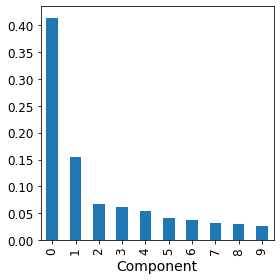

In [260]:
sp_pca = PCA()
sp_pca.fit(sp500_red)

explained_variance = pd.DataFrame(sp_pca.explained_variance_ratio_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

The components

In [252]:
pca.components_

array([[ 0.36138659, -0.08452251,  0.85667061,  0.3582892 ],
       [ 0.65658877,  0.73016143, -0.17337266, -0.07548102]])

We can how much of the variance we want to explain, and get the corrisponding number of PC.

In [266]:
pca1=PCA()
pca1.fit(sp500_red)
cumsum=np.cumsum(pca1.explained_variance_ratio_)
d=np.argmax(cumsum>=0.95)+1
d

12

Or alternatively

In [268]:
pca2=PCA(n_components=0.95)
pca2.fit(sp500_red)
pca2.n_components_

10

#### Another exampe with the MNIST dataset

In [300]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

In [278]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [279]:
d

154

Find the optimal number of PC using the elbow method

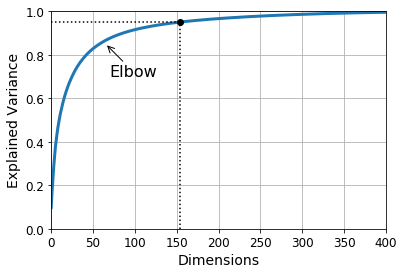

In [280]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
#save_fig("explained_variance_plot")
plt.show()

In [30]:
np.sum(pca.explained_variance_ratio_)

0.950349970207861

Find the inverse transform

In [283]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X)
X_recovered = pca.inverse_transform(X_reduced)

In [284]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

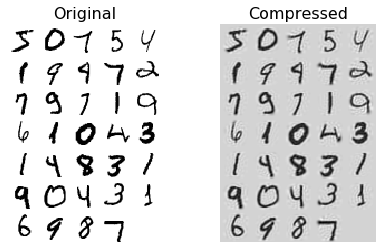

In [285]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

#save_fig("mnist_compression_plot")

### Projection - LDA
Linear Discriminant Analysis

In [189]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import load_wine

In [290]:
dt = load_wine()
X = dt.data
y = dt.target
lda = LinearDiscriminantAnalysis(n_components=2)
lda_t = lda.fit_transform(X,y)
lda.explained_variance_ratio_

array([0.68747889, 0.31252111])

In [291]:
X.shape

(178, 13)

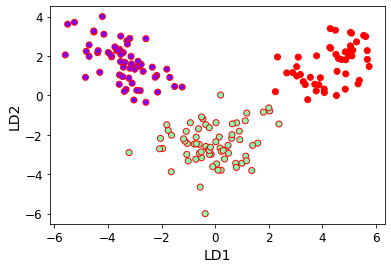

In [292]:
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.scatter(lda_t[:,0],lda_t[:,1],c=y,cmap='rainbow',edgecolors='r')

## Other methods
We create a swiss-roll dataset and then unravel it using different methods

In [139]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

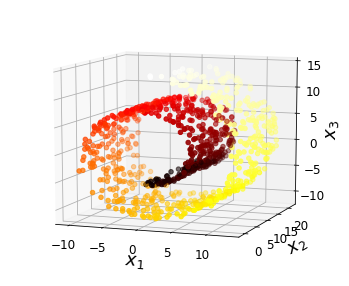

In [144]:
from mpl_toolkits.mplot3d import Axes3D
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

#### Locally Linear Embedding - LLE

In [140]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

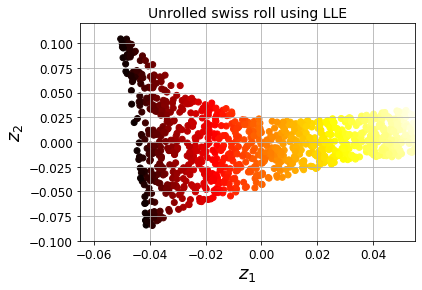

In [142]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

#save_fig("lle_unrolling_plot")
plt.show()

#### Multidimensional scaling

In [ ]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

#### Isomap

In [146]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components
                =2)
X_reduced_isomap = isomap.fit_transform(X)

#### t-SNE

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

#### LDA
Note that here we use the MNIST dataset because we need a target variable.

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

In [ ]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

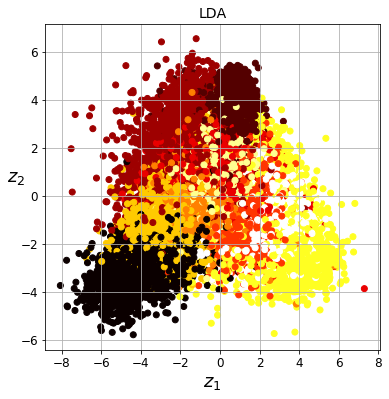

In [158]:
titles = ["LDA"]

plt.figure(figsize=(6,6))
plt.subplot()
plt.title("LDA", fontsize=14)
plt.scatter(X_reduced_lda[:, 0], X_reduced_lda[:, 1],c=y_mnist, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()